In [5]:
import cv2
import time
import onnxruntime as ort
import numpy as np

# Chuẩn bị ảnh đầu vào mẫu
img_path = "C:/Users/Trung/Downloads/duc.png"  # ảnh chứa 1 hoặc nhiều khuôn mặt
img = cv2.imread(img_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Hàm benchmark thời gian chạy
def benchmark(func, iterations=20):
    times = []
    for _ in range(iterations):
        start = time.time()
        func()
        times.append(time.time() - start)
    return np.mean(times), np.std(times)

# Viola-Jones (Haar Cascade) - chỉ hỗ trợ CPU
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
def detect_haar():
    _ = face_cascade.detectMultiScale(gray, 1.3, 5)

haar_mean, haar_std = benchmark(detect_haar)

# YuNet (ONNX) - hỗ trợ CPU và GPU

def detect_yunet_cpu():
    yunet_cpu = cv2.FaceDetectorYN.create(
        model="D:/Door_Lock_App/models/face_detection_yunet_2023mar.onnx",
        config="",
        input_size=(img.shape[1], img.shape[0]),
        score_threshold=0.9,
        backend_id=cv2.dnn.DNN_BACKEND_DEFAULT,
        target_id=cv2.dnn.DNN_TARGET_CPU
    )
    _ = yunet_cpu.detect(img)

def detect_yunet_gpu():
    yunet_gpu = cv2.FaceDetectorYN.create(
        model="D:/Door_Lock_App/models/face_detection_yunet_2023mar.onnx",
        config="",
        input_size=(img.shape[1], img.shape[0]),
        score_threshold=0.9,
        backend_id=cv2.dnn.DNN_BACKEND_CUDA,
        target_id=cv2.dnn.DNN_TARGET_CUDA
    )
    _ = yunet_gpu.detect(img)


yunet_cpu_mean, yunet_cpu_std = benchmark(detect_yunet_cpu)
# yunet_gpu_mean, yunet_gpu_std = benchmark(detect_yunet_gpu)

# EdgeFace (ONNX) nhận diện khuôn mặt từ ảnh đã cắt
edgeface_sess_cpu = ort.InferenceSession("./models/edgeface_xs_gamma_06.onnx", providers=["CPUExecutionProvider"])
if 'CUDAExecutionProvider' in ort.get_available_providers():
    edgeface_sess_gpu = ort.InferenceSession("./models/edgeface_xs_gamma_06.onnx", providers=["CUDAExecutionProvider"])
else:
    edgeface_sess_gpu = None

dummy_face = np.random.rand(1, 3, 112, 112).astype(np.float32)  # ảnh khuôn mặt giả


def recognize_edgeface_cpu():
    _ = edgeface_sess_cpu.run(None, {"input.1": dummy_face})

def recognize_edgeface_gpu():
    if edgeface_sess_gpu:
        _ = edgeface_sess_gpu.run(None, {"input.1": dummy_face})

edge_cpu_mean, edge_cpu_std = benchmark(recognize_edgeface_cpu)
edge_gpu_mean, edge_gpu_std = benchmark(recognize_edgeface_gpu) if edgeface_sess_gpu else (None, None)

# In kết quả
print("⏱️ Benchmark kết quả:")
print(f"Viola-Jones (CPU): {haar_mean:.4f} ± {haar_std:.4f} sec")
print(f"YuNet (CPU):       {yunet_cpu_mean:.4f} ± {yunet_cpu_std:.4f} sec")
# print(f"YuNet (GPU):       {yunet_gpu_mean:.4f} ± {yunet_gpu_std:.4f} sec")
print(f"EdgeFace (CPU):    {edge_cpu_mean:.4f} ± {edge_cpu_std:.4f} sec")
if edge_gpu_mean:
    print(f"EdgeFace (GPU):    {edge_gpu_mean:.4f} ± {edge_gpu_std:.4f} sec")
else:
    print("EdgeFace (GPU):    ❌ GPU không khả dụng")


⏱️ Benchmark kết quả:
Viola-Jones (CPU): 0.0159 ± 0.0027 sec
YuNet (CPU):       0.0311 ± 0.0040 sec
EdgeFace (CPU):    0.0044 ± 0.0021 sec
EdgeFace (GPU):    0.0068 ± 0.0086 sec


In [ ]:
import onnxruntime as ort
import numpy as np
import time

# Thay đổi cho phù hợp với input thực tế của bạn
input_shape = (1, 3, 128, 128)  # Ví dụ mô hình nhận diện khuôn mặt EdgeFace
dummy_input = np.random.rand(*input_shape).astype(np.float32)

def benchmark_onnx(session, input_name, input_tensor, iterations=50):
    times = []
    for _ in range(iterations):
        start = time.time()
        session.run(None, {input_name: input_tensor})
        times.append(time.time() - start)
    return np.mean(times), np.std(times)


# Tên input biết trước
input_name = "input"  # thay bằng tên đúng của bạn

# Load ONNX model
model_path = "./models/AntiSpoofing_cls2_bbox2_sz128_128_best.onnx"  # thay bằng đường dẫn của bạn

# Session CPU
sess_cpu = ort.InferenceSession(model_path, providers=["CPUExecutionProvider"])

# Session GPU (nếu hỗ trợ)
sess_gpu = None
if "CUDAExecutionProvider" in ort.get_available_providers():
    sess_gpu = ort.InferenceSession(model_path, providers=["CUDAExecutionProvider"])

cpu_mean, cpu_std = benchmark_onnx(sess_cpu, input_name, dummy_input)
print(f"🧠 CPU Inference: {cpu_mean:.4f} ± {cpu_std:.4f} seconds")

if sess_gpu:
    gpu_mean, gpu_std = benchmark_onnx(sess_gpu, input_name, dummy_input)
    print(f"🚀 GPU Inference: {gpu_mean:.4f} ± {gpu_std:.4f} seconds")
else:
    print("❌ GPU không khả dụng hoặc onnxruntime-gpu chưa được cài")



🧠 CPU Inference: 0.0056 ± 0.0053 seconds
🚀 GPU Inference: 0.0056 ± 0.0057 seconds



📊 AUC: 0.9485 | Best Threshold: 0.3968
Mean same score: 0.6116
Mean diff score: 0.1828


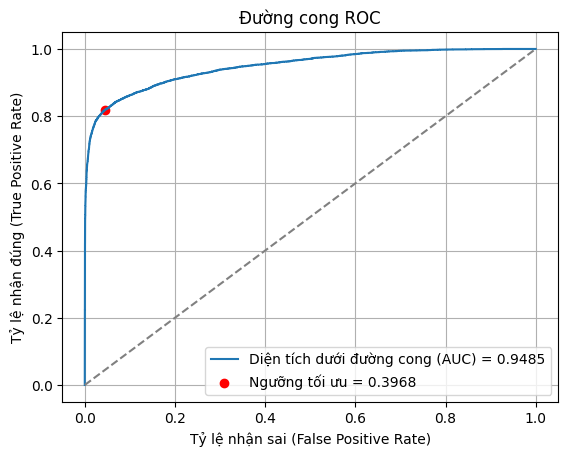

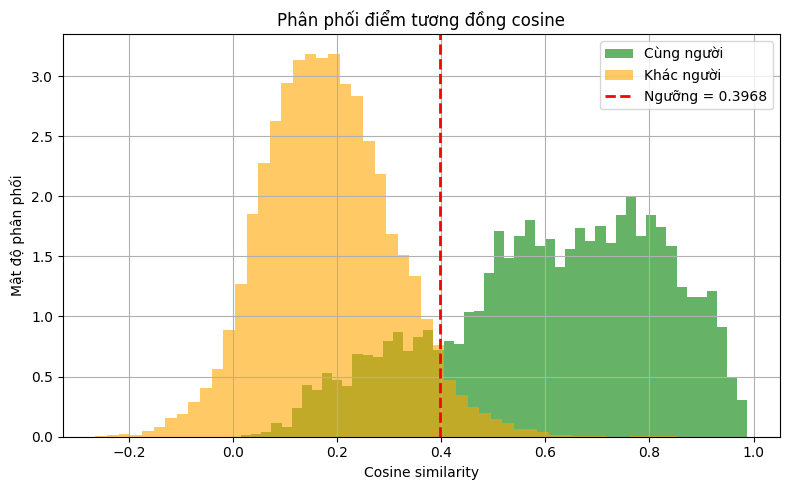

🔍 Accuracy:  0.9282
🔍 Precision: 0.8170
🔍 Recall:    0.8192
🔍 F1-score:  0.8181


0.3967962861061096

In [5]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import os
from itertools import combinations
from retinaface import RetinaFace
from sklearn.metrics.pairwise import cosine_similarity
import onnxruntime
import cv2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


def detect_and_align_face(img_path, target_size=(112, 112)):
    img = cv2.imread(img_path)
    faces = RetinaFace.detect_faces(img)
    if not isinstance(faces, dict) or len(faces) == 0:
        raise ValueError(f"No face detected in {img_path}")
    face_key = max(faces, key=lambda k: faces[k]["facial_area"][2] * faces[k]["facial_area"][3])
    x1, y1, x2, y2 = faces[face_key]["facial_area"]
    face = img[y1:y2, x1:x2]
    face = cv2.resize(face, target_size)
    face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
    return face.astype(np.float32)


def preprocess_image(face):
    face = face / 255.0
    face = (face - 0.5) / 0.5
    face = np.transpose(face, (2, 0, 1))
    face = np.expand_dims(face, axis=0)
    return face.astype(np.float32)


def load_model(onnx_path):
    session = onnxruntime.InferenceSession(onnx_path)
    input_name = session.get_inputs()[0].name
    return session, input_name


def get_embedding(session, input_name, img_tensor):
    embedding = session.run(None, {input_name: img_tensor})[0]
    return embedding / np.linalg.norm(embedding)


def compute_similarity(emb1, emb2):
    return float(cosine_similarity(emb1, emb2)[0][0])


def evaluate_threshold_roc(model_path, root_dir):
    session, input_name = load_model(model_path)

    # Tải embedding từng ảnh
    person_dirs = sorted([os.path.join(root_dir, d) for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
    person_embeddings = {}

    for person_path in person_dirs:
        person_name = os.path.basename(person_path)
        embeddings = []
        for fname in os.listdir(person_path):
            img_path = os.path.join(person_path, fname)
            try:
                face = detect_and_align_face(img_path)
                emb = get_embedding(session, input_name, preprocess_image(face))
                embeddings.append((img_path, emb))
            except Exception as e:
                print(f"Skip {img_path}: {e}")
        if embeddings:
            person_embeddings[person_name] = embeddings

    # Tạo cặp same và diff
    same_scores, diff_scores = [], []

    for person, embs in person_embeddings.items():
        for (path1, emb1), (path2, emb2) in combinations(embs, 2):
            score = compute_similarity(emb1, emb2)
            same_scores.append(score)

    persons = list(person_embeddings.keys())
    for i in range(len(persons)):
        for j in range(i + 1, len(persons)):
            for _, emb1 in person_embeddings[persons[i]]:
                for _, emb2 in person_embeddings[persons[j]]:
                    score = compute_similarity(emb1, emb2)
                    diff_scores.append(score)

    # Tổng hợp nhãn và điểm
    scores = same_scores + diff_scores
    labels = [1] * len(same_scores) + [0] * len(diff_scores)

    # ROC & AUC
    fpr, tpr, thresholds = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)
    best_idx = np.argmax(tpr - fpr)
    best_threshold = thresholds[best_idx]

    # In kết quả
    print(f"\n📊 AUC: {roc_auc:.4f} | Best Threshold: {best_threshold:.4f}")
    print(f"Mean same score: {np.mean(same_scores):.4f}")
    print(f"Mean diff score: {np.mean(diff_scores):.4f}")

    # Vẽ ROC
    plt.figure()
    plt.plot(fpr, tpr, label=f'Diện tích dưới đường cong (AUC) = {roc_auc:.4f}')
    plt.scatter(fpr[best_idx], tpr[best_idx], color='red', label=f'Ngưỡng tối ưu = {best_threshold:.4f}')
    plt.plot([0, 1], [0, 1], '--', color='gray')
    plt.title('Đường cong ROC')
    plt.xlabel('Tỷ lệ nhận sai (False Positive Rate)')
    plt.ylabel('Tỷ lệ nhận đúng (True Positive Rate)')
    plt.legend()
    plt.grid()
    plt.show()

    # Vẽ biểu đồ phân phối similarity
    plt.figure(figsize=(8, 5))
    plt.hist(same_scores, bins=50, alpha=0.6, label='Cùng người', color='green', density=True)
    plt.hist(diff_scores, bins=50, alpha=0.6, label='Khác người', color='orange', density=True)
    plt.axvline(best_threshold, color='red', linestyle='--', linewidth=2, label=f'Ngưỡng = {best_threshold:.4f}')
    plt.title("Phân phối điểm tương đồng cosine")
    plt.xlabel("Cosine similarity")
    plt.ylabel("Mật độ phân phối")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

     # Dự đoán nhị phân theo threshold tối ưu
    predictions = [1 if s >= best_threshold else 0 for s in scores]

    # Tính các chỉ số phân loại
    acc = accuracy_score(labels, predictions)
    prec = precision_score(labels, predictions)
    rec = recall_score(labels, predictions)
    f1 = f1_score(labels, predictions)

    # In kết quả đánh giá chi tiết
    print(f"🔍 Accuracy:  {acc:.4f}")
    print(f"🔍 Precision: {prec:.4f}")
    print(f"🔍 Recall:    {rec:.4f}")
    print(f"🔍 F1-score:  {f1:.4f}")

    return best_threshold

evaluate_threshold_roc(
    model_path="./models/edgeface_s_gamma_05.onnx",
    root_dir="C:/Users/Trung/Downloads/Camera Roll - Copy/"
)




📊 AUC: 0.9581 | Best Threshold: 0.2860
Mean same score: 0.5629
Mean diff score: 0.1371


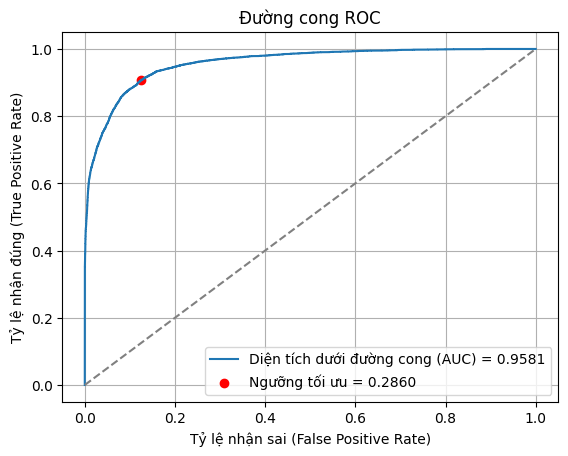

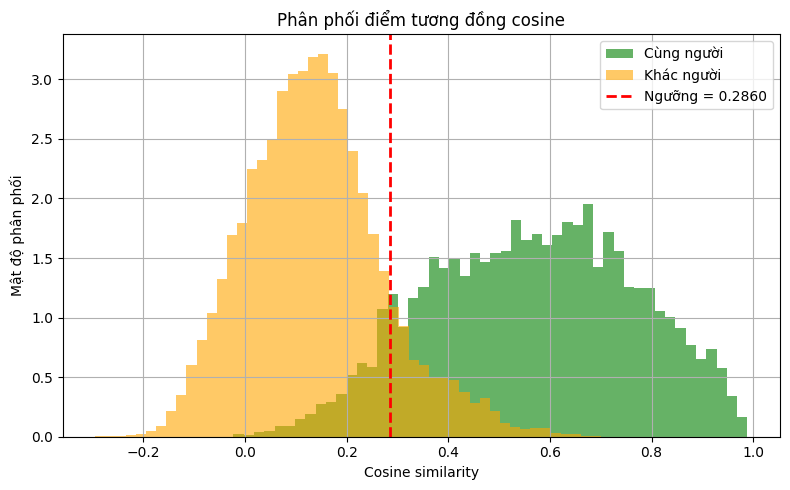

🔍 Accuracy:  0.8817
🔍 Precision: 0.6416
🔍 Recall:    0.9066
🔍 F1-score:  0.7514


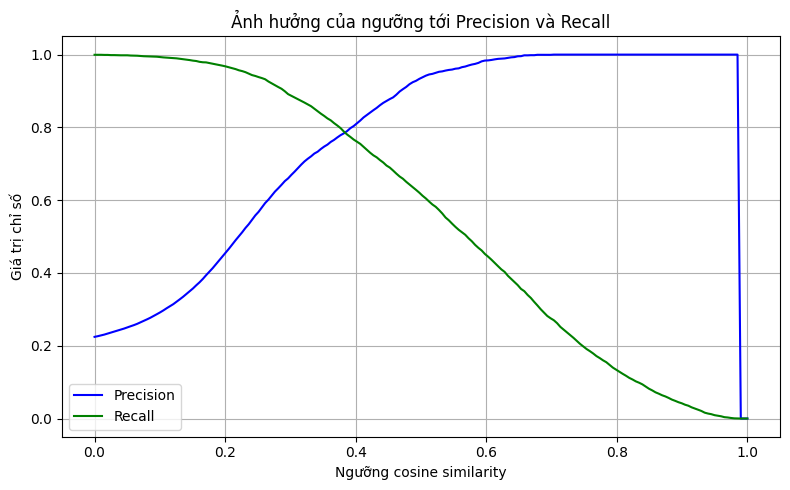

0.28596869111061096

In [14]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import os
from itertools import combinations
from retinaface import RetinaFace
from sklearn.metrics.pairwise import cosine_similarity
import onnxruntime
import cv2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


def detect_and_align_face(img_path, target_size=(112, 112)):
    img = cv2.imread(img_path)
    faces = RetinaFace.detect_faces(img)
    if not isinstance(faces, dict) or len(faces) == 0:
        raise ValueError(f"No face detected in {img_path}")
    face_key = max(faces, key=lambda k: faces[k]["facial_area"][2] * faces[k]["facial_area"][3])
    x1, y1, x2, y2 = faces[face_key]["facial_area"]
    face = img[y1:y2, x1:x2]
    face = cv2.resize(face, target_size)
    face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
    return face.astype(np.float32)


def preprocess_image(face):
    face = face / 255.0
    face = (face - 0.5) / 0.5
    face = np.transpose(face, (2, 0, 1))
    face = np.expand_dims(face, axis=0)
    return face.astype(np.float32)


def load_model(onnx_path):
    session = onnxruntime.InferenceSession(onnx_path)
    input_name = session.get_inputs()[0].name
    return session, input_name


def get_embedding(session, input_name, img_tensor):
    embedding = session.run(None, {input_name: img_tensor})[0]
    return embedding / np.linalg.norm(embedding)


def compute_similarity(emb1, emb2):
    return float(cosine_similarity(emb1, emb2)[0][0])


def evaluate_threshold_roc(model_path, root_dir):
    session, input_name = load_model(model_path)

    # Tải embedding từng ảnh
    person_dirs = sorted([os.path.join(root_dir, d) for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
    person_embeddings = {}

    for person_path in person_dirs:
        person_name = os.path.basename(person_path)
        embeddings = []
        for fname in os.listdir(person_path):
            img_path = os.path.join(person_path, fname)
            try:
                face = detect_and_align_face(img_path)
                emb = get_embedding(session, input_name, preprocess_image(face))
                embeddings.append((img_path, emb))
            except Exception as e:
                print(f"Skip {img_path}: {e}")
        if embeddings:
            person_embeddings[person_name] = embeddings

    # Tạo cặp same và diff
    same_scores, diff_scores = [], []

    for person, embs in person_embeddings.items():
        for (path1, emb1), (path2, emb2) in combinations(embs, 2):
            score = compute_similarity(emb1, emb2)
            same_scores.append(score)

    persons = list(person_embeddings.keys())
    for i in range(len(persons)):
        for j in range(i + 1, len(persons)):
            for _, emb1 in person_embeddings[persons[i]]:
                for _, emb2 in person_embeddings[persons[j]]:
                    score = compute_similarity(emb1, emb2)
                    diff_scores.append(score)

    # Tổng hợp nhãn và điểm
    scores = same_scores + diff_scores
    labels = [1] * len(same_scores) + [0] * len(diff_scores)

    # ROC & AUC
    fpr, tpr, thresholds = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)
    best_idx = np.argmax(tpr - fpr)
    best_threshold = thresholds[best_idx]

    # In kết quả
    print(f"\n📊 AUC: {roc_auc:.4f} | Best Threshold: {best_threshold:.4f}")
    print(f"Mean same score: {np.mean(same_scores):.4f}")
    print(f"Mean diff score: {np.mean(diff_scores):.4f}")

    # Vẽ ROC
    plt.figure()
    plt.plot(fpr, tpr, label=f'Diện tích dưới đường cong (AUC) = {roc_auc:.4f}')
    plt.scatter(fpr[best_idx], tpr[best_idx], color='red', label=f'Ngưỡng tối ưu = {best_threshold:.4f}')
    plt.plot([0, 1], [0, 1], '--', color='gray')
    plt.title('Đường cong ROC')
    plt.xlabel('Tỷ lệ nhận sai (False Positive Rate)')
    plt.ylabel('Tỷ lệ nhận đúng (True Positive Rate)')
    plt.legend()
    plt.grid()
    plt.show()

    # Vẽ biểu đồ phân phối similarity
    plt.figure(figsize=(8, 5))
    plt.hist(same_scores, bins=50, alpha=0.6, label='Cùng người', color='green', density=True)
    plt.hist(diff_scores, bins=50, alpha=0.6, label='Khác người', color='orange', density=True)
    plt.axvline(best_threshold, color='red', linestyle='--', linewidth=2, label=f'Ngưỡng = {best_threshold:.4f}')
    plt.title("Phân phối điểm tương đồng cosine")
    plt.xlabel("Cosine similarity")
    plt.ylabel("Mật độ phân phối")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

     # Dự đoán nhị phân theo threshold tối ưu
    predictions = [1 if s >= best_threshold else 0 for s in scores]

    # Tính các chỉ số phân loại
    acc = accuracy_score(labels, predictions)
    prec = precision_score(labels, predictions)
    rec = recall_score(labels, predictions)
    f1 = f1_score(labels, predictions)

    # In kết quả đánh giá chi tiết
    print(f"🔍 Accuracy:  {acc:.4f}")
    print(f"🔍 Precision: {prec:.4f}")
    print(f"🔍 Recall:    {rec:.4f}")
    print(f"🔍 F1-score:  {f1:.4f}")

    # Vẽ ảnh hưởng của ngưỡng tới Precision và Recall
    thresholds_range = np.linspace(0, 1, 200)
    precisions, recalls = [], []

    for t in thresholds_range:
        preds = [1 if s >= t else 0 for s in scores]
        precisions.append(precision_score(labels, preds, zero_division=0))
        recalls.append(recall_score(labels, preds, zero_division=0))

    plt.figure(figsize=(8, 5))
    plt.plot(thresholds_range, precisions, label='Precision', color='blue')
    plt.plot(thresholds_range, recalls, label='Recall', color='green')
    # plt.axvline(best_threshold, color='red', linestyle='--', label=f'Ngưỡng tối ưu = {best_threshold:.4f}')
    plt.xlabel("Ngưỡng cosine similarity")
    plt.ylabel("Giá trị chỉ số")
    plt.title("Ảnh hưởng của ngưỡng tới Precision và Recall")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return best_threshold

evaluate_threshold_roc(
    model_path="./models/edgeface_xs_gamma_06.onnx",
    root_dir="C:/Users/Trung/Downloads/Camera Roll - Copy/"
)



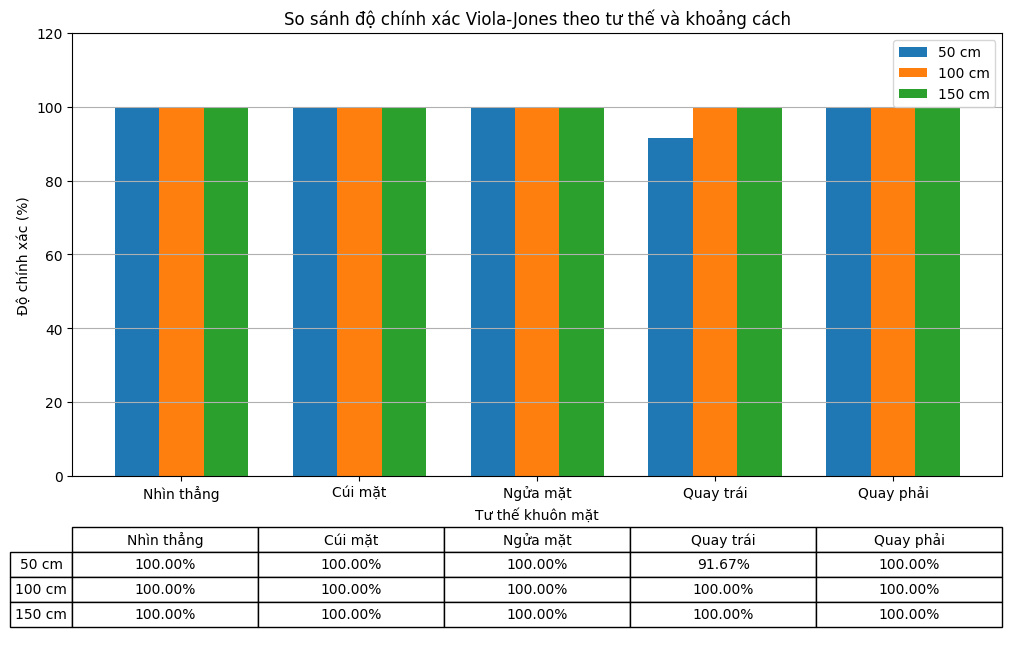

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# ==== NHẬP DỮ LIỆU ====
pose_labels = ["Nhìn thẳng", "Cúi mặt", "Ngửa mặt", "Quay trái", "Quay phải"]

accuracy_50cm = [100.0, 100.0, 100.0, 91.66666667, 100.0]
accuracy_100cm = [100.0, 100.0, 100.0, 100.0, 100.0]
accuracy_150cm = [100.0, 100.0, 100.0, 100.0, 100.0]

# ==== TẠO BỐ CỤC BIỂU ĐỒ + BẢNG ====
fig = plt.figure(figsize=(12, 8))
gs = GridSpec(2, 1, height_ratios=[4, 1.3], hspace=0.1)

# ==== TRỤC 1: BIỂU ĐỒ ====
ax1 = fig.add_subplot(gs[0])

bar_width = 0.25
x = np.arange(len(pose_labels))

ax1.bar(x - bar_width, accuracy_50cm, width=bar_width, label='50 cm', color='tab:blue')
ax1.bar(x, accuracy_100cm, width=bar_width, label='100 cm', color='tab:orange')
ax1.bar(x + bar_width, accuracy_150cm, width=bar_width, label='150 cm', color='tab:green')

ax1.set_xlabel("Tư thế khuôn mặt")
ax1.set_ylabel("Độ chính xác (%)")
ax1.set_title("So sánh độ chính xác Viola-Jones theo tư thế và khoảng cách")
ax1.set_xticks(x)
ax1.set_xticklabels(pose_labels)
ax1.set_ylim(0, 120)
ax1.legend()
ax1.grid(True, axis='y')

# ==== TRỤC 2: BẢNG ====
ax2 = fig.add_subplot(gs[1])
ax2.axis('off')  # Ẩn trục bảng

# Dữ liệu bảng
table_data = [
    [f"{v:.2f}%" for v in accuracy_50cm],
    [f"{v:.2f}%" for v in accuracy_100cm],
    [f"{v:.2f}%" for v in accuracy_150cm]
]
row_labels = ['50 cm', '100 cm', '150 cm']
col_labels = pose_labels

# Tạo bảng
table = ax2.table(cellText=table_data,
                  rowLabels=row_labels,
                  colLabels=col_labels,
                  cellLoc='center',
                  rowLoc='center',
                  loc='center')
table.scale(1, 1.5)

plt.tight_layout()
plt.show()


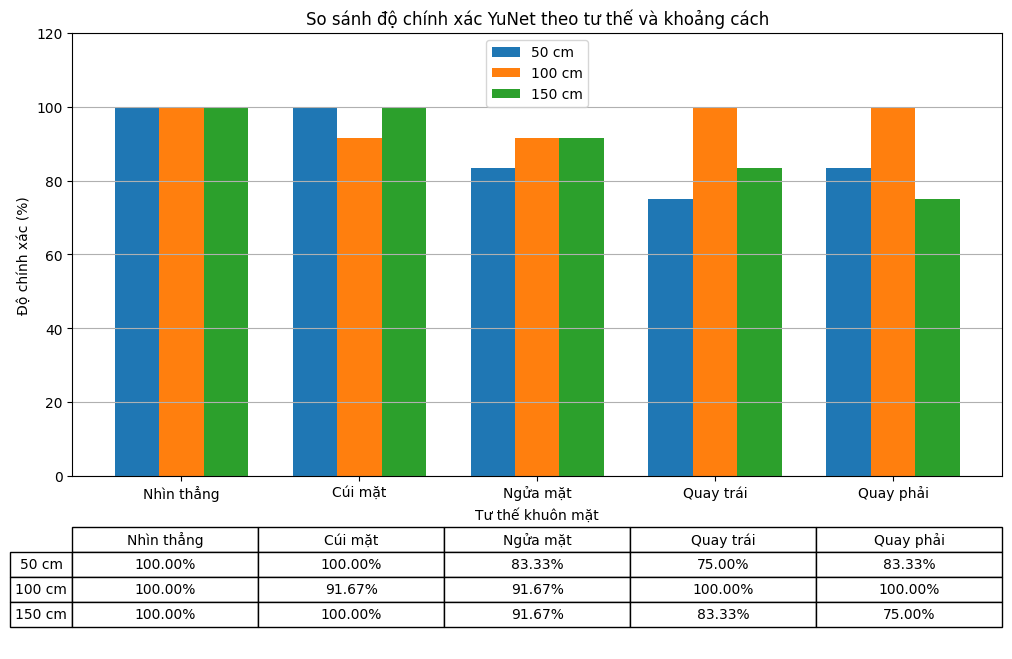

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# ==== NHẬP DỮ LIỆU ====
pose_labels = ["Nhìn thẳng", "Cúi mặt", "Ngửa mặt", "Quay trái", "Quay phải"]

accuracy_50cm = [100.0, 100.0, 83.33333333, 75.0, 83.33333333]
accuracy_100cm = [100.0, 91.66666667, 91.66666667, 100.0, 100.0]
accuracy_150cm = [100.0, 100.0, 91.66666667, 83.33333333, 75.0]

# ==== TẠO BỐ CỤC BIỂU ĐỒ + BẢNG ====
fig = plt.figure(figsize=(12, 8))
gs = GridSpec(2, 1, height_ratios=[4, 1.3], hspace=0.1)

# ==== TRỤC 1: BIỂU ĐỒ ====
ax1 = fig.add_subplot(gs[0])

bar_width = 0.25
x = np.arange(len(pose_labels))

ax1.bar(x - bar_width, accuracy_50cm, width=bar_width, label='50 cm', color='tab:blue')
ax1.bar(x, accuracy_100cm, width=bar_width, label='100 cm', color='tab:orange')
ax1.bar(x + bar_width, accuracy_150cm, width=bar_width, label='150 cm', color='tab:green')

ax1.set_xlabel("Tư thế khuôn mặt")
ax1.set_ylabel("Độ chính xác (%)")
ax1.set_title("So sánh độ chính xác YuNet theo tư thế và khoảng cách")
ax1.set_xticks(x)
ax1.set_xticklabels(pose_labels)
ax1.set_ylim(0, 120)
ax1.legend()
ax1.grid(True, axis='y')

# ==== TRỤC 2: BẢNG ====
ax2 = fig.add_subplot(gs[1])
ax2.axis('off')  # Ẩn trục bảng

# Dữ liệu bảng
table_data = [
    [f"{v:.2f}%" for v in accuracy_50cm],
    [f"{v:.2f}%" for v in accuracy_100cm],
    [f"{v:.2f}%" for v in accuracy_150cm]
]
row_labels = ['50 cm', '100 cm', '150 cm']
col_labels = pose_labels

# Tạo bảng
table = ax2.table(cellText=table_data,
                  rowLabels=row_labels,
                  colLabels=col_labels,
                  cellLoc='center',
                  rowLoc='center',
                  loc='center')
table.scale(1, 1.5)

plt.tight_layout()
plt.show()


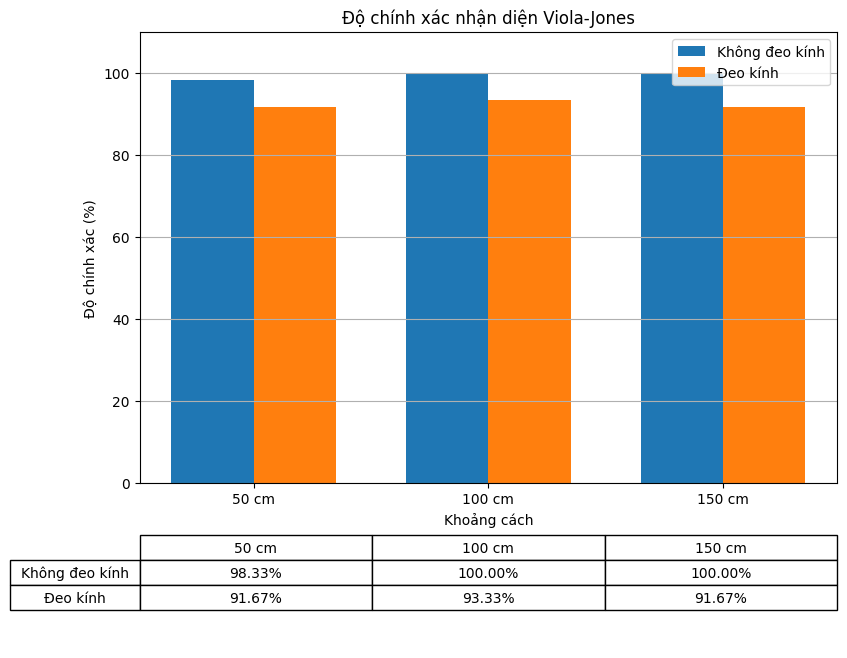

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# ==== DỮ LIỆU ====
distance_labels = ["50 cm", "100 cm", "150 cm"]
no_glasses_accuracy = np.array([98.3333333, 100, 100])
glasses_accuracy = np.array([91.66666667, 93.33333333, 91.66666667])

# ==== TẠO BỐ CỤC 2 TRỤC: 1 CHO BIỂU ĐỒ, 1 CHO BẢNG ====
fig = plt.figure(figsize=(9, 8))
gs = GridSpec(2, 1, height_ratios=[3, 1], hspace=0.05)  # tỉ lệ 3:1 giữa biểu đồ và bảng

# ==== TRỤC 1: BIỂU ĐỒ ====
ax1 = fig.add_subplot(gs[0])

bar_width = 0.35
index = np.arange(len(distance_labels))

ax1.bar(index - bar_width/2, no_glasses_accuracy, bar_width, label='Không đeo kính', color='tab:blue')
ax1.bar(index + bar_width/2, glasses_accuracy, bar_width, label='Đeo kính', color='tab:orange')

ax1.set_xlabel("Khoảng cách")
ax1.set_ylabel("Độ chính xác (%)")
ax1.set_title("Độ chính xác nhận diện Viola-Jones")
ax1.set_xticks(index)
ax1.set_xticklabels(distance_labels)
ax1.set_ylim(0, 110)
ax1.legend()
ax1.grid(True, axis='y')

# ==== TRỤC 2: BẢNG ====
ax2 = fig.add_subplot(gs[1])
ax2.axis('off')  # Ẩn trục

# Tạo bảng dữ liệu
table_data = [
    [f"{val:.2f}%" for val in no_glasses_accuracy],
    [f"{val:.2f}%" for val in glasses_accuracy]
]
row_labels = ['Không đeo kính', 'Đeo kính']
col_labels = distance_labels

# Hiển thị bảng
table = ax2.table(cellText=table_data,
                  rowLabels=row_labels,
                  colLabels=col_labels,
                  cellLoc='center',
                  rowLoc='center',
                  loc='center')

table.scale(1, 1.5)  # Phóng to bảng

plt.tight_layout()
plt.show()


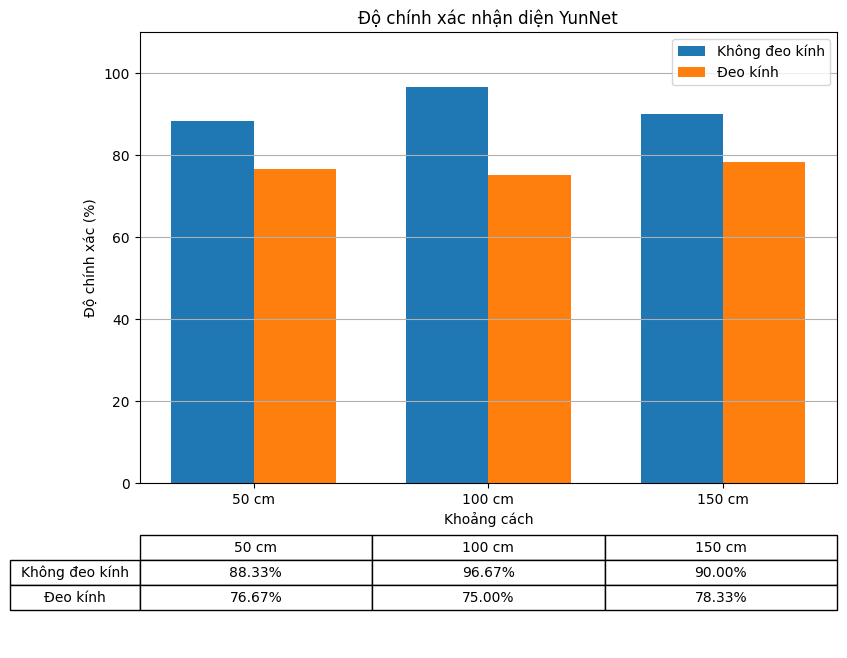

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# ==== DỮ LIỆU ====
distance_labels = ["50 cm", "100 cm", "150 cm"]
no_glasses_accuracy = np.array([88.33333333, 96.66666667, 90])
glasses_accuracy = np.array([76.66666667, 75, 78.33333333])

# ==== TẠO BỐ CỤC 2 TRỤC: 1 CHO BIỂU ĐỒ, 1 CHO BẢNG ====
fig = plt.figure(figsize=(9, 8))
gs = GridSpec(2, 1, height_ratios=[3, 1], hspace=0.05)  # tỉ lệ 3:1 giữa biểu đồ và bảng

# ==== TRỤC 1: BIỂU ĐỒ ====
ax1 = fig.add_subplot(gs[0])

bar_width = 0.35
index = np.arange(len(distance_labels))

ax1.bar(index - bar_width/2, no_glasses_accuracy, bar_width, label='Không đeo kính', color='tab:blue')
ax1.bar(index + bar_width/2, glasses_accuracy, bar_width, label='Đeo kính', color='tab:orange')

ax1.set_xlabel("Khoảng cách")
ax1.set_ylabel("Độ chính xác (%)")
ax1.set_title("Độ chính xác nhận diện YunNet")
ax1.set_xticks(index)
ax1.set_xticklabels(distance_labels)
ax1.set_ylim(0, 110)
ax1.legend()
ax1.grid(True, axis='y')

# ==== TRỤC 2: BẢNG ====
ax2 = fig.add_subplot(gs[1])
ax2.axis('off')  # Ẩn trục

# Tạo bảng dữ liệu
table_data = [
    [f"{val:.2f}%" for val in no_glasses_accuracy],
    [f"{val:.2f}%" for val in glasses_accuracy]
]
row_labels = ['Không đeo kính', 'Đeo kính']
col_labels = distance_labels

# Hiển thị bảng
table = ax2.table(cellText=table_data,
                  rowLabels=row_labels,
                  colLabels=col_labels,
                  cellLoc='center',
                  rowLoc='center',
                  loc='center')

table.scale(1, 1.5)  # Phóng to bảng

plt.tight_layout()
plt.show()


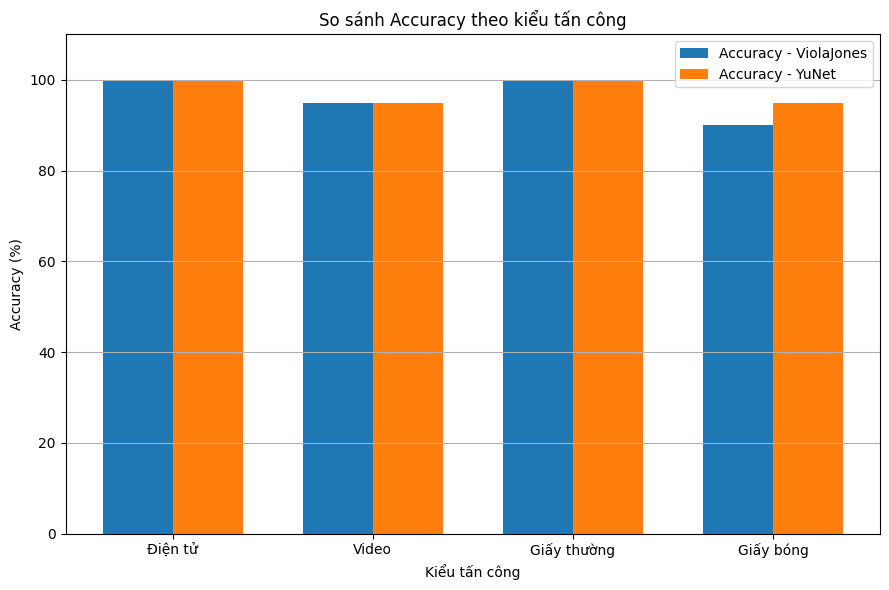

In [19]:
# Re-import necessary libraries after code execution environment reset
import numpy as np
import matplotlib.pyplot as plt

# Nhãn kiểu tấn công
attack_types = ["Điện tử", "Video", "Giấy thường", "Giấy bóng"]

# Độ chính xác (%) = số lần phát hiện đúng / tổng (20 mẫu mỗi loại)
accuracy_viola = np.array([100, 95, 100, 90])
accuracy_yunet = np.array([100, 95, 100, 95])

# Vẽ biểu đồ cột
bar_width = 0.35
index = np.arange(len(attack_types))

fig, ax = plt.subplots(figsize=(9, 6))

# Cột độ chính xác
ax.bar(index - bar_width/2, accuracy_viola, bar_width, label='Accuracy - ViolaJones', color='tab:blue')
ax.bar(index + bar_width/2, accuracy_yunet, bar_width, label='Accuracy - YuNet', color='tab:orange')

# Gán nhãn và định dạng
ax.set_xlabel("Kiểu tấn công")
ax.set_ylabel("Accuracy (%)")
ax.set_title("So sánh Accuracy theo kiểu tấn công")
ax.set_xticks(index)
ax.set_xticklabels(attack_types)
ax.set_ylim(0, 110)
ax.legend()
ax.grid(True, axis='y')

plt.tight_layout()
plt.show()


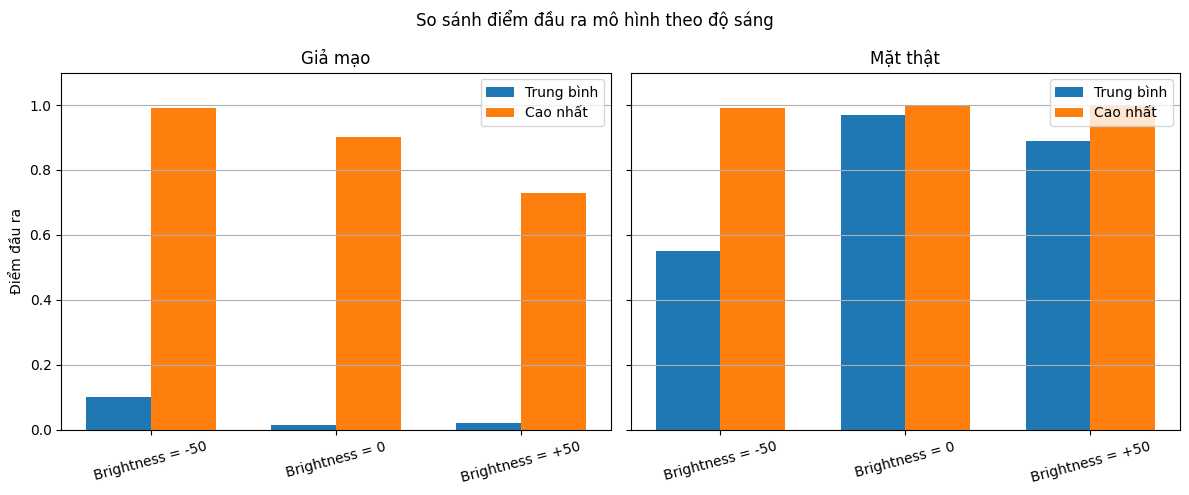

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Dữ liệu
brightness_labels = ["Brightness = -50", "Brightness = 0", "Brightness = +50"]

# Ảnh giả
fake_mean = [0.1000, 0.0154, 0.0197]
fake_max = [0.9900, 0.9000, 0.7300]

# Ảnh thật
real_mean = [0.5500, 0.9700, 0.8900]
real_max = [0.9900, 1.0000, 1.0000]

x = np.arange(len(brightness_labels))
width = 0.35  # chiều rộng của cột

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Vẽ biểu đồ cho ảnh giả
ax1.bar(x - width/2, fake_mean, width, label='Trung bình', color='tab:blue')
ax1.bar(x + width/2, fake_max, width, label='Cao nhất', color='tab:orange')
ax1.set_title("Giả mạo")
ax1.set_xticks(x)
ax1.set_xticklabels(brightness_labels, rotation=15)
ax1.set_ylabel("Điểm đầu ra")
ax1.set_ylim(0, 1.1)
ax1.legend()
ax1.grid(True, axis='y')

# Vẽ biểu đồ cho ảnh thật
ax2.bar(x - width/2, real_mean, width, label='Trung bình', color='tab:blue')
ax2.bar(x + width/2, real_max, width, label='Cao nhất', color='tab:orange')
ax2.set_title("Mặt thật")
ax2.set_xticks(x)
ax2.set_xticklabels(brightness_labels, rotation=15)
ax2.legend()
ax2.grid(True, axis='y')

fig.suptitle("So sánh điểm đầu ra mô hình theo độ sáng")
plt.tight_layout()
plt.show()

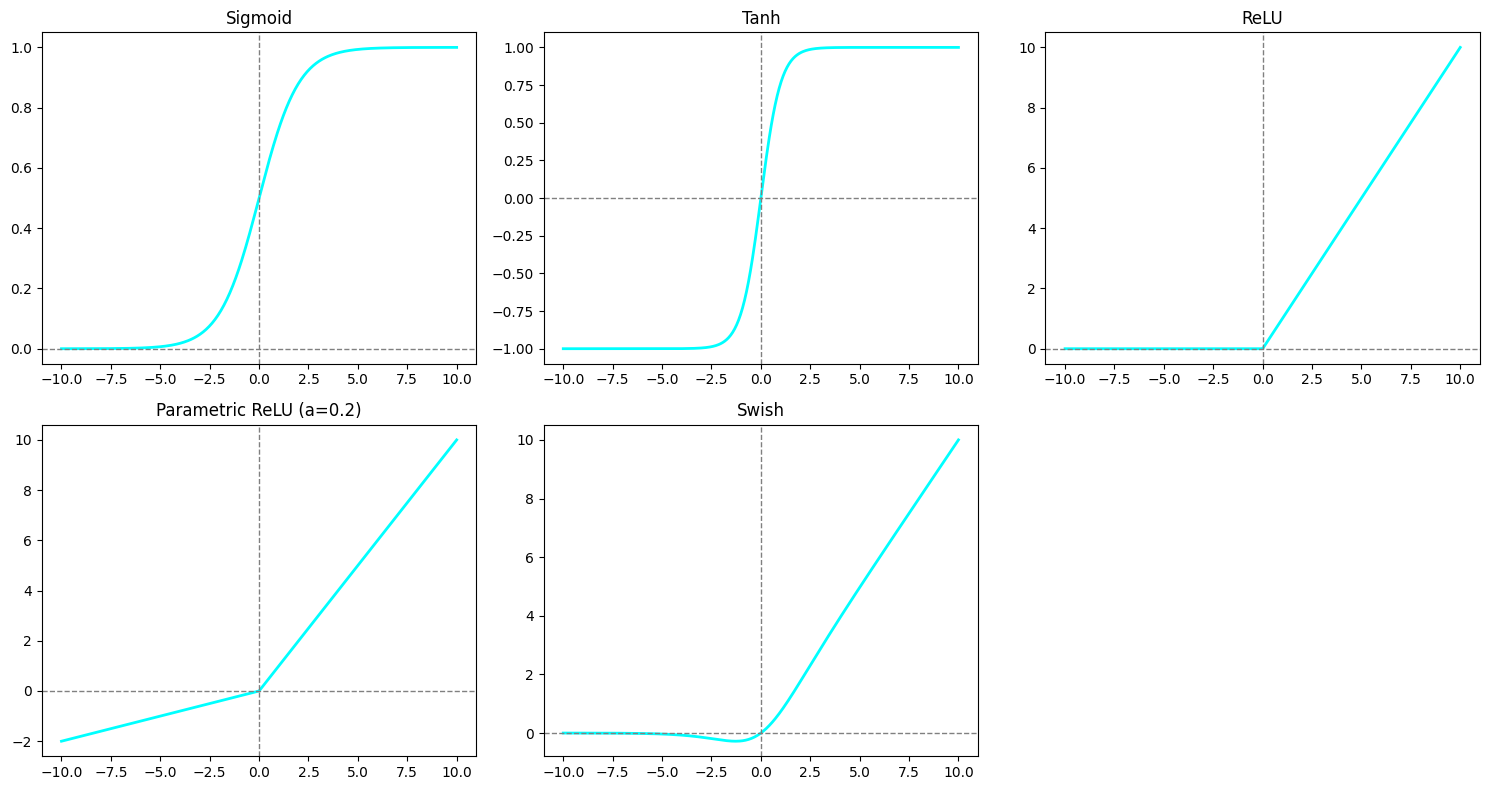

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Hàm Sigmoid
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Hàm Tanh
def tanh(x):
    return np.tanh(x)

# Hàm ReLU
def relu(x):
    return np.maximum(0, x)

# Hàm Parametric ReLU
def parametric_relu(x, a=0.2):
    return np.where(x >= 0, x, a * x)

# Hàm Swish
def swish(x):
    return x * sigmoid(x)

# Trục x
x = np.linspace(-10, 10, 400)

# Tạo subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 8))
axs = axs.flatten()

# Danh sách hàm và tiêu đề
functions = [
    (sigmoid, "Sigmoid"),
    (tanh, "Tanh"),
    (relu, "ReLU"),
    (parametric_relu, "Parametric ReLU (a=0.2)"),
    (swish, "Swish")
]

# Vẽ từng hàm + trục x=0
for i, (func, title) in enumerate(functions):
    axs[i].plot(x, func(x), color='cyan', linewidth=2)
    axs[i].axvline(x=0, color='gray', linestyle='--', linewidth=1)  # Thêm trục x=0
    axs[i].axhline(y=0, color='gray', linestyle='--', linewidth=1)
    axs[i].set_title(title)
    axs[i].grid(False)

# Ẩn subplot cuối cùng (trống)
axs[5].axis('off')

# Hiển thị
plt.tight_layout()
plt.show()


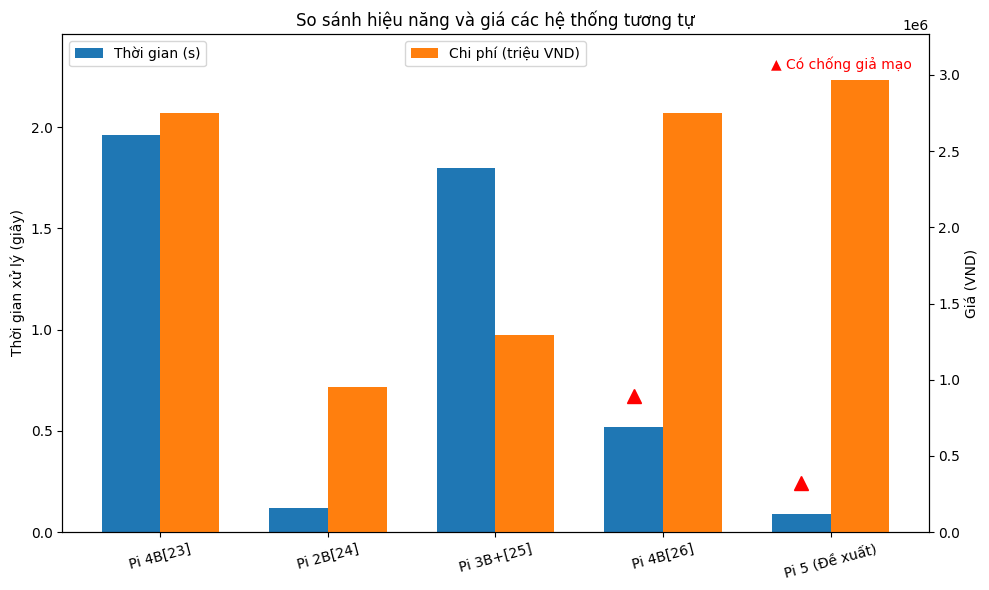

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Tên thiết bị
devices = ['Pi 4B[23]', 'Pi 2B[24]', 'Pi 3B+[25]', 'Pi 4B[26]', 'Pi 5 (Đề xuất)']
# Thời gian thực thi (s)
times = [1.96, 0.12, 1.80, 0.52, 0.09]
# Giá tiền: chỉ lấy giá cao nhất nếu có dao động
prices = [2750000, 950000, 1292500, 2750000, 2970000]
# Có chống giả mạo hay không
has_anti_spoofing = [False, False, False, True, True]

x = np.arange(len(devices))
width = 0.35

price_max = max(prices)
price_buffer = 300000

fig, ax1 = plt.subplots(figsize=(10, 6))

# Vẽ cột thời gian
bar1 = ax1.bar(x - width/2, times, width, label='Thời gian (s)', color='tab:blue')
ax1.set_ylabel('Thời gian xử lý (giây)')
ax1.set_ylim(0, max(times) + 0.5)
ax1.set_xticks(x)
ax1.set_xticklabels(devices, rotation=15)
ax1.set_title('So sánh hiệu năng và giá các hệ thống tương tự')

# Vẽ cột giá cao nhất
ax2 = ax1.twinx()
bar2 = ax2.bar(x + width/2, prices, width, label='Giá (VND)', color='tab:orange')
ax2.set_ylabel('Giá (VND)')
ax2.set_ylim(0, price_max + price_buffer)

# Đánh dấu thiết bị có chống giả mạo
for i in range(len(devices)):
    if has_anti_spoofing[i]:
        ax1.plot(x[i] - width/2, times[i] + 0.15, marker='^', color='red', markersize=10)

# Ghi chú chống giả mạo
ax1.annotate('▲ Có chống giả mạo', xy=(0.98, 0.93), xycoords='axes fraction',
             ha='right', fontsize=10, color='red')

# Chú thích
ax1.legend([bar1], ['Thời gian (s)'], loc='upper left')
ax2.legend([bar2], ['Chi phí (triệu VND)'], loc='upper center')

plt.tight_layout()
plt.show()
